In [1]:
import os
import numpy as np
import torch
import torch.optim as optim
from torchvision.transforms import ToTensor
from torch import nn
import matplotlib.pyplot as plt
from PIL import Image, ImageFile
from segmentation_models_pytorch.losses import DiceLoss
from tqdm import tqdm
from torchvision.utils import save_image

from sam2.build_sam import build_sam2, build_sam2_video_predictor
from sam2.sam2_image_predictor import SAM2ImagePredictor

/home/user20/segment-anything-2/sam2/modeling/sam/transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


In [2]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

# if device.type == "cuda":
#     # use bfloat16 for the entire notebook
#     torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
#     # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
#     if torch.cuda.get_device_properties(0).major >= 8:
#         torch.backends.cuda.matmul.allow_tf32 = True
#         torch.backends.cudnn.allow_tf32 = True

using device: cuda:0


In [3]:
np.random.seed(3)

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True, save_to=None):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        if save_to:
            plt.gca().set_axis_off()
            plt.subplots_adjust(
                top=1,
                bottom=0, 
                right=1,
                left=0, 
                hspace=0,
                wspace=0
            )
            plt.margins(0,0)
            plt.savefig(save_to, bbox_inches='tight', pad_inches=0)
            plt.close()
        else:
            plt.show()

def show_image(image_array):
    if isinstance(image_array, torch.Tensor):
        plt.imshow(image_array.numpy())
    elif isinstance(image_array, np.ndarray):
        plt.imshow(image_array)
    else:
        raise NotImplementedError("Image format not supported")
    plt.axis('off')
    plt.title('Image')
    plt.show()

In [4]:
def build_sam2_image_predictor(sam2_checkpoint="../../checkpoints/sam2_hiera_large.pt", model_cfg="sam2_hiera_l.yaml"):
    sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

    predictor = SAM2ImagePredictor(sam2_model)

    for param in predictor.model.parameters():
        param.requires_grad = False
    
    return predictor

def get_mask_logo(resize_to_shape, logo_path='../images/airi_logo.jpg'):
    airi_logo = Image.open(logo_path)
    airi_logo = np.array(airi_logo.convert("RGB"))

    airi_logo = Image.fromarray(airi_logo)
    airi_logo = airi_logo.resize(resize_to_shape) # transformed_image.shape[1:][::-1]

    airi_logo = np.array(airi_logo)
    airi_logo[airi_logo <= 200] = 1
    airi_logo[airi_logo > 200] = 0

    airi_logo = np.any(airi_logo, axis=2)
    airi_logo = airi_logo[None, ...]
    airi_logo = torch.from_numpy(airi_logo)
    airi_logo = airi_logo.to(device=device, dtype=torch.float32)

    return airi_logo

def get_image_predict(predictor, image, input_point, input_label=np.array([1])):
    predictor.set_image(image)
    return predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=False,
        return_logits=False,
    )

In [17]:
def train_init(image_path):
    initial_image = Image.open(image_path)

    epsilon = torch.tensor(5./255, dtype=torch.float32, device=device)

    tensor_initial_image = ToTensor()(initial_image)
    tensor_initial_image = tensor_initial_image.to(device=device)

    delta = torch.zeros_like(tensor_initial_image, requires_grad=True)

    return tensor_initial_image, delta, epsilon

def save_adv_image(predictor, initial_image, delta, epsilon, input_point, input_label, adv_image_path="asd", delta_image_path="asd"):
    adv_mask = get_mask_logo(resize_to_shape=initial_image.shape[1:][::-1])
    opt = optim.Adam([delta], lr=0.001)

    dice_loss = DiceLoss('binary', from_logits=True)

    losses = []
    for t in tqdm(range(600)):
        opt.zero_grad()
        predictor.set_image(initial_image + delta)
        masks, _, _ = predictor.predict(
            point_coords=input_point,
            point_labels=input_label,
            multimask_output=False,
            return_logits=True,
        )

        loss = dice_loss(masks, adv_mask)

        losses.append(loss.item())
        
        loss.backward()
        opt.step()
        delta.data.clamp_(-epsilon, epsilon)

    adv_image = (initial_image + delta).detach().cpu().clip(0, 1)

    save_image(adv_image, adv_image_path)
    save_image(delta.detach().cpu().clip(0, 1), delta_image_path)
    
    return losses, adv_image

def save_adv_image_with_different_points(predictor, initial_image, delta, epsilon, adv_image_path="asd", delta_image_path="asd"):
    adv_mask = get_mask_logo(resize_to_shape=initial_image.shape[1:][::-1])
    opt = optim.Adam([delta], lr=0.001)

    dice_loss = DiceLoss('binary', from_logits=True)
    losses = []
    input_label = np.array([1])
    for t in tqdm(range(1500)):
        opt.zero_grad()
        input_point = np.array([[np.random.rand(1)[0] * initial_image.shape[2], np.random.rand(1)[0] * initial_image.shape[1]]])
        predictor.set_image(initial_image + delta)
        masks, _, _ = predictor.predict(
            point_coords=input_point,
            point_labels=input_label,
            multimask_output=False,
            return_logits=True,
        )
        loss = dice_loss(masks, adv_mask)

        losses.append(loss.item())
        
        loss.backward()
        opt.step()
        delta.data.clamp_(-epsilon, epsilon)

    adv_image = (initial_image + delta).detach().cpu().clip(0, 1)

    save_image(adv_image, adv_image_path)
    save_image(delta.detach().cpu().clip(0, 1), delta_image_path)
    
    return losses, adv_image

def save_image_with_mask(image, mask: np.ndarray, out_image_path, alpha=0.7):
    if isinstance(image, ImageFile.ImageFile):
        image = (np.array(image) / 255.).transpose(2, 0, 1)

    mask = np.stack([mask[0] * 87./255, mask[0] * 186./255, mask[0] * 168./255])

    image_transparency = (image * (1 - alpha) + mask * alpha).clip(0, 1)

    image = np.where(mask, image_transparency, image).clip(0, 1)
    image = Image.fromarray((image.transpose(1, 2, 0) * 255).astype(dtype=np.uint8))

    # tmp_name = (tmp + str(counter))[-5:]
    # image.save(f"./videos/adv_bedroom_with_mask/{tmp_name}.png")
    image.save(out_image_path)

def plot_loss(losses, loss_label):
    plt.figure(figsize=(5, 3))
    plt.plot(losses, label=loss_label)
    plt.title('Loss Plot')
    plt.xlabel('Iterations')
    plt.ylabel(f'{loss_label} plot')
    plt.grid(True)
    plt.legend()
    plt.show()

In [21]:
predictor = build_sam2_image_predictor()
initial_image, delta, epsilon = train_init('../images/groceries.jpg')
points = np.array([
    [[400, 300]],
])
labels = np.array([[1]])

In [22]:
losses, adv_groceries_truck = save_adv_image(predictor, initial_image, delta, epsilon, points, labels, f'../images/adv_groceries.png', '../images/delta_groceries.png')

  1%|          | 5/600 [00:02<04:31,  2.19it/s]

100%|██████████| 600/600 [05:35<00:00,  1.79it/s]


In [26]:
adv_image_truck, _, _ = train_init('../images/adv_truck.png')

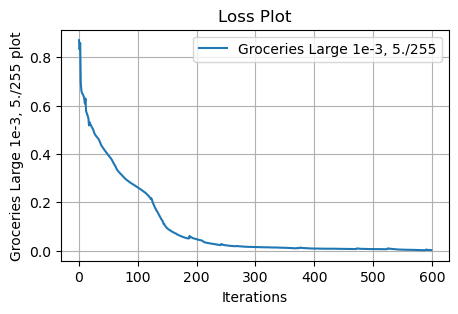

In [23]:
plot_loss(losses, "Groceries Large 1e-3, 5./255")

In [26]:
masks_new, scores_new, logits = get_image_predict(predictor, adv_groceries_truck, points[0])

In [29]:
show_masks(adv_groceries_truck.detach().cpu().clip(0, 1).permute(1, 2, 0), masks_new.detach().cpu().numpy(), scores_new, points[0], None, np.array([1]), save_to=f"../images/adv_groceries_with_mask.png")

In [97]:
for i in tqdm(range(20)):
    input_point = np.array([[np.random.rand(1)[0] * initial_image.shape[2], np.random.rand(1)[0] * initial_image.shape[1]]])
    masks_new, scores_new, logits = get_image_predict(predictor, adv_image_truck, input_point)
    name = f"0000{i}"[-5:]
    show_masks(adv_image_truck.detach().cpu().clip(0, 1).permute(1, 2, 0), masks_new.detach().cpu().numpy(), scores_new, input_point, None, np.array([1]), save_to=f"../images/children_diff_points_large_model/{name}.png")

100%|██████████| 20/20 [00:19<00:00,  1.03it/s]


In [42]:
input_point = np.array([[np.random.rand(1)[0] * initial_image.shape[0], np.random.rand(1)[0] * initial_image.shape[1]]])
input_point

array([[  1.47131372, 972.67156554]])

In [17]:
type(adv_image_truck)

torch.Tensor

In [20]:
adv_image_truck.shape

torch.Size([3, 1200, 1800])

In [7]:
adv_image_truck, _, _ = train_init('../images/trunk.jpg')

FileNotFoundError: [Errno 2] No such file or directory: '/home/user20/segment-anything-2/notebooks/images/trunk.png'

In [31]:
input_point = np.array([[np.random.rand(1)[0] * initial_image.shape[2], np.random.rand(1)[0] * initial_image.shape[1]]])
masks_new, scores_new, logits = get_image_predict(predictor, adv_image_truck, input_point)
for i in tqdm(range(100)):
    name = f"0000{i}"[-5:]
    # save_image_with_mask(adv_image_truck.detach().cpu().numpy(), masks_new.detach().cpu().numpy(), f"../images/truck_diff_points/{name}.png")
    show_masks(adv_image_truck.detach().cpu().clip(0, 1).permute(1, 2, 0), masks_new.detach().cpu().numpy(), scores_new, input_point, None, np.array([1]), save_to="")

  0%|          | 0/100 [00:00<?, ?it/s]

0.0 1.0
0.0 1.0


  1%|          | 1/100 [00:00<01:11,  1.39it/s]

0.0 1.0
0.0 1.0


  2%|▏         | 2/100 [00:01<01:10,  1.40it/s]

0.0 1.0
0.0 1.0


  3%|▎         | 3/100 [00:02<01:09,  1.40it/s]

0.0 1.0
0.0 1.0


  4%|▍         | 4/100 [00:02<01:08,  1.40it/s]

0.0 1.0
0.0 1.0


  5%|▌         | 5/100 [00:03<01:07,  1.40it/s]

0.0 1.0
0.0 1.0


  6%|▌         | 6/100 [00:04<01:07,  1.40it/s]

0.0 1.0
0.0 1.0


  7%|▋         | 7/100 [00:04<01:06,  1.40it/s]

0.0 1.0
0.0 1.0


  8%|▊         | 8/100 [00:05<01:05,  1.41it/s]

0.0 1.0
0.0 1.0


  9%|▉         | 9/100 [00:06<01:04,  1.41it/s]

0.0 1.0
0.0 1.0


 10%|█         | 10/100 [00:07<01:03,  1.41it/s]

0.0 1.0
0.0 1.0


 11%|█         | 11/100 [00:07<01:03,  1.41it/s]

0.0 1.0
0.0 1.0


 12%|█▏        | 12/100 [00:08<01:02,  1.41it/s]

0.0 1.0
0.0 1.0


 13%|█▎        | 13/100 [00:09<01:01,  1.41it/s]

0.0 1.0
0.0 1.0


 14%|█▍        | 14/100 [00:09<01:01,  1.40it/s]

0.0 1.0
0.0 1.0


 15%|█▌        | 15/100 [00:10<01:00,  1.40it/s]

0.0 1.0
0.0 1.0


 16%|█▌        | 16/100 [00:11<01:00,  1.40it/s]

0.0 1.0
0.0 1.0


 17%|█▋        | 17/100 [00:12<00:59,  1.39it/s]

0.0 1.0
0.0 1.0


 18%|█▊        | 18/100 [00:12<00:58,  1.39it/s]

0.0 1.0
0.0 1.0


 19%|█▉        | 19/100 [00:13<00:57,  1.40it/s]

0.0 1.0
0.0 1.0


 20%|██        | 20/100 [00:14<01:01,  1.31it/s]

0.0 1.0
0.0 1.0


 21%|██        | 21/100 [00:15<01:02,  1.25it/s]

0.0 1.0
0.0 1.0


 22%|██▏       | 22/100 [00:16<01:03,  1.22it/s]

0.0 1.0
0.0 1.0


 23%|██▎       | 23/100 [00:16<01:02,  1.23it/s]

0.0 1.0
0.0 1.0


 24%|██▍       | 24/100 [00:17<00:59,  1.27it/s]

0.0 1.0
0.0 1.0


 25%|██▌       | 25/100 [00:18<00:57,  1.31it/s]

0.0 1.0
0.0 1.0


 26%|██▌       | 26/100 [00:19<00:55,  1.33it/s]

0.0 1.0
0.0 1.0


 27%|██▋       | 27/100 [00:19<00:54,  1.33it/s]

0.0 1.0
0.0 1.0


 28%|██▊       | 28/100 [00:20<00:53,  1.34it/s]

0.0 1.0
0.0 1.0


 29%|██▉       | 29/100 [00:21<00:52,  1.35it/s]

0.0 1.0
0.0 1.0


 30%|███       | 30/100 [00:22<00:51,  1.36it/s]

0.0 1.0
0.0 1.0


 31%|███       | 31/100 [00:22<00:50,  1.37it/s]

0.0 1.0
0.0 1.0


 32%|███▏      | 32/100 [00:23<00:49,  1.38it/s]

0.0 1.0
0.0 1.0


 33%|███▎      | 33/100 [00:24<00:48,  1.39it/s]

0.0 1.0
0.0 1.0


 34%|███▍      | 34/100 [00:24<00:47,  1.39it/s]

0.0 1.0
0.0 1.0


 35%|███▌      | 35/100 [00:25<00:46,  1.39it/s]

0.0 1.0
0.0 1.0


 36%|███▌      | 36/100 [00:26<00:45,  1.40it/s]

0.0 1.0
0.0 1.0


 37%|███▋      | 37/100 [00:27<00:44,  1.40it/s]

0.0 1.0
0.0 1.0


 38%|███▊      | 38/100 [00:27<00:45,  1.36it/s]


0.0 1.0
0.0 1.0


KeyboardInterrupt: 

In [21]:
input_point

array([[3.59913723e-01, 5.71604522e+02]])

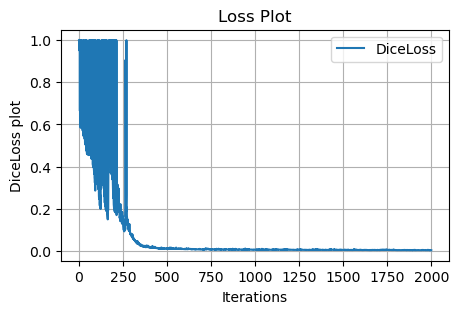

In [16]:
plot_loss(losses=losses, loss_label='DiceLoss')

In [2]:
adv_images_truck

NameError: name 'adv_images_truck' is not defined

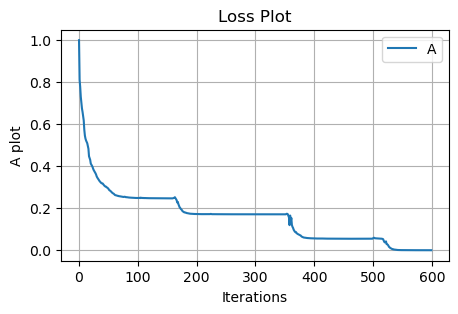

In [ ]:
plot_loss(losses, "A")

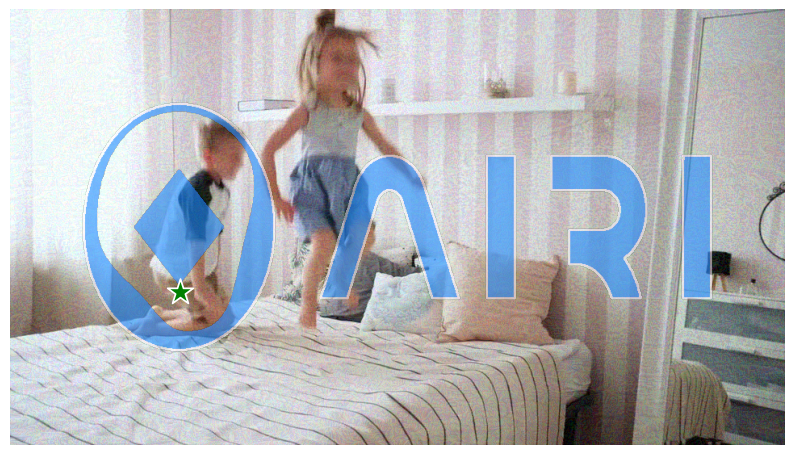

In [27]:
masks_new, scores_new, logits = get_image_predict(predictor, adv_image_childrens, input_point, input_label)
show_masks(adv_image_childrens.detach().cpu().clip(0, 1).permute(1, 2, 0), masks_new.detach().cpu().numpy() > 0, scores_new, input_point, None, input_label)

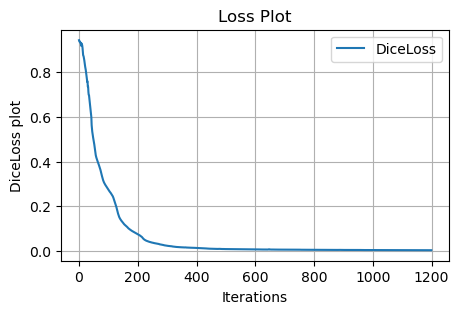

In [23]:
plot_loss(losses, 'DiceLoss')

In [25]:
masks_new, scores_new, logits = get_image_predict(predictor, adv_image_childrens, input_point, input_label)

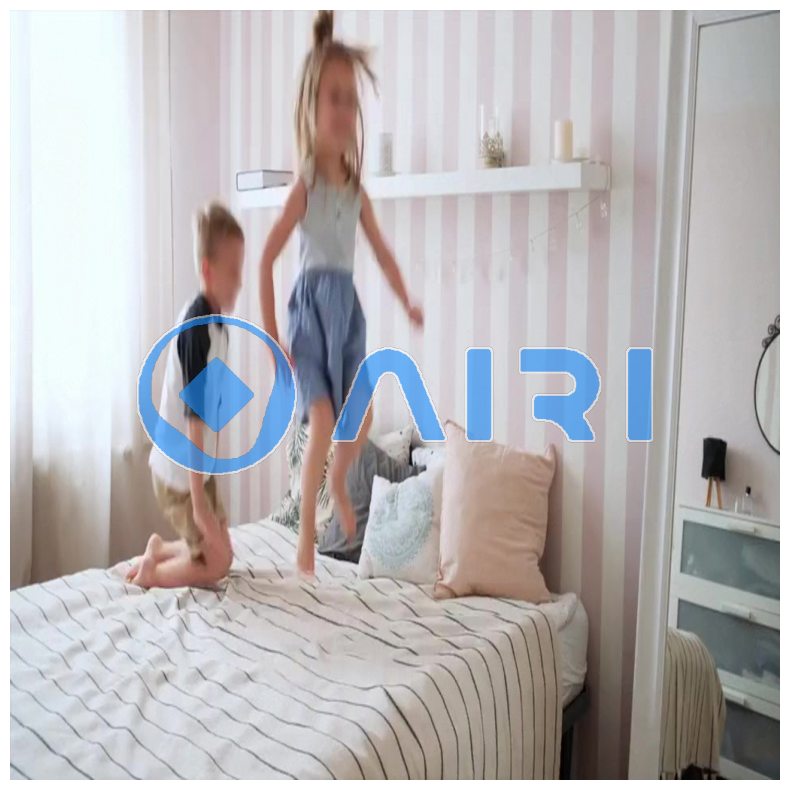

In [50]:
show_masks(adv_image_childrens.detach().cpu().clip(0, 1).permute(1, 2, 0), masks_new.detach().cpu().numpy() > 0, scores_new)

In [51]:
adv_image_childrens.shape

torch.Size([3, 1024, 1024])

In [35]:
losses, adv_image_childrens_without_epsion = save_adv_image(predictor, '../videos/bedroom/00000.jpg', input_point, input_label, 'children_without_esposion.png')

100%|██████████| 1200/1200 [02:31<00:00,  7.94it/s]


initial_image tensor(0., device='cuda:0') tensor(1., device='cuda:0')
delta tensor(-0.0646, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0646, device='cuda:0', grad_fn=<MaxBackward1>)


In [40]:
10./255

0.0392156862745098

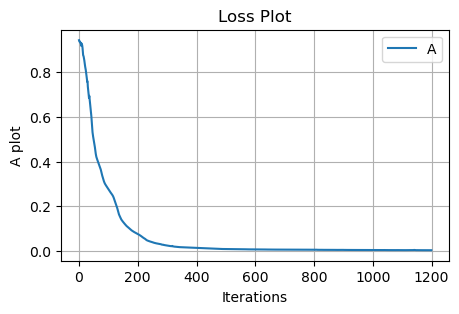

In [36]:
plot_loss(losses, "A")

In [ ]:
masks_new_wo_eps, scores_new_wo_eps, logits_wo_eps = get_image_predict(predictor, adv_image_childrens_without_epsion, input_point, input_label)

In [ ]:
show_masks(adv_image_childrens_without_epsion.detach().cpu().clip(0, 1).permute(1, 2, 0), masks_new_wo_eps.detach().cpu().numpy() > 0, scores_new_wo_eps)

In [21]:
initial_image, delta, epsilon = train_init('../images/truck.jpg')
input_point = np.array([[500, 375]])
input_label = np.array([1])
adv_mask = get_mask_logo(resize_to_shape=initial_image.shape[1:][::-1])

In [7]:
initial_image, delta, epsilon = train_init('../videos/adv_bedroom/00000.png')
input_point = np.array([[210, 350]])
input_label = np.array([1])
adv_mask = get_mask_logo(resize_to_shape=initial_image.shape[1:][::-1])

In [8]:
opt = optim.Adam([delta], lr=1e-4)

cross_entropy_loss = nn.CrossEntropyLoss()
dice_loss = DiceLoss('binary', from_logits=True)

predictor = build_sam2_image_predictor()

: 

In [23]:
losses = []

In [24]:
for t in tqdm(range(1200)):
    opt.zero_grad()
    predictor.set_image(initial_image + delta)
    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=False,
        return_logits=True,
    )
    # masks = torch.sigmoid(masks)
    loss = dice_loss(masks, adv_mask)
    losses.append(loss.item())
       
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)

100%|██████████| 1200/1200 [02:31<00:00,  7.94it/s]


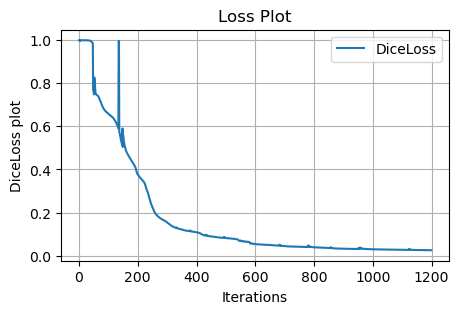

In [25]:
plot_loss(losses, 'DiceLoss')

In [32]:
masks_new, scores_new, logits = get_image_predict(predictor, adv_image_track_from_saved, input_point, input_label)

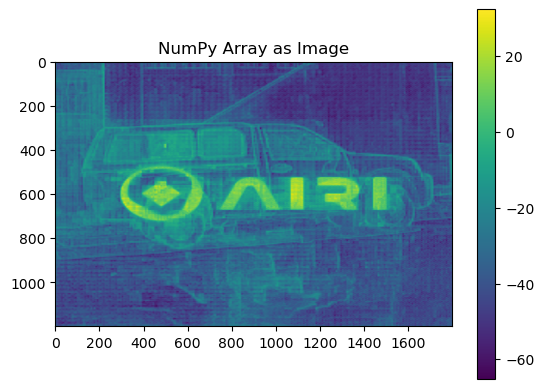

In [27]:
plt.imshow(np.squeeze(masks_new.detach().cpu().numpy()), cmap='viridis')  # You can change the colormap using the 'cmap' parameter
plt.colorbar()  # Add a colorbar to the side
plt.title("NumPy Array as Image")
plt.show()

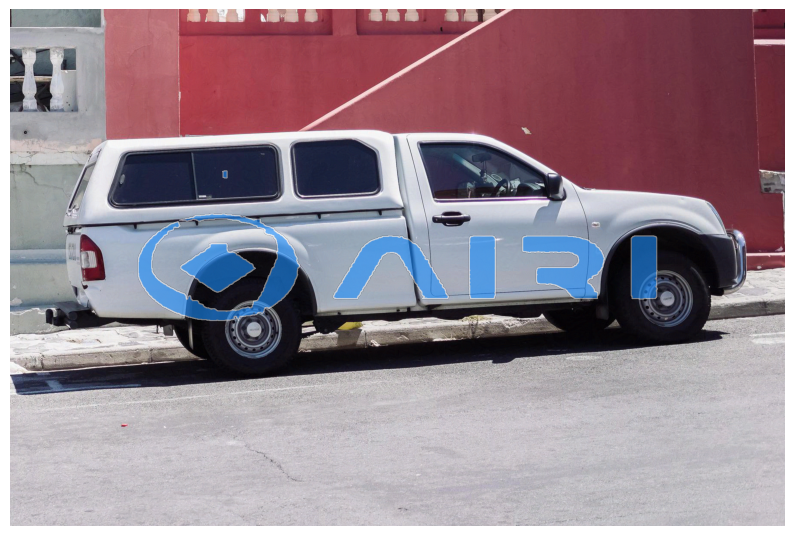

In [33]:
show_masks(adv_image_track_from_saved.detach().cpu().clip(0, 1).permute(1, 2, 0), masks_new.detach().cpu().numpy() > 0, scores_new)

In [51]:
masks_new, scores_new, logits = get_image_predict(predictor, initial_image + delta, input_point, input_label)

In [12]:
adv_image = Image.open('adv_image.png')
adv_transformed_image = torch.from_numpy(np.array(adv_image)) / 255
adv_transformed_image = adv_transformed_image.to(device=device)

In [17]:
predictor.set_image(adv_transformed_image.permute(2, 0, 1))
masks_new, scores_new, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False,
    return_logits=True,
)

In [14]:
adv_transformed_image.min(), adv_transformed_image.max()

NameError: name 'adv_transformed_image' is not defined

In [16]:
predictor = build_sam2_image_predictor()
points = np.array([
    [400, 300],
    [630, 300],
], dtype=np.float32)
labels = np.array([1, 1], np.int32)
losses, adv_bedroom_image = save_adv_image_with_different_points(predictor, , '../images/groceries.jpg', '../images/adv_images/groceries.png')

  0%|          | 4/1200 [00:00<02:31,  7.87it/s]

100%|██████████| 1200/1200 [02:29<00:00,  8.03it/s]


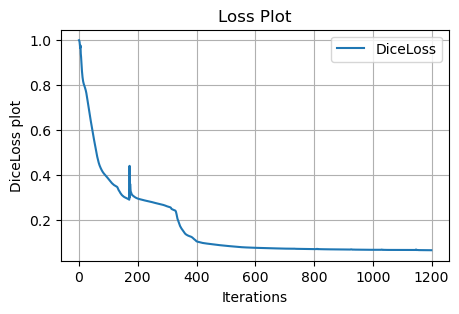

In [17]:
plot_loss(losses, 'DiceLoss')

In [18]:
predictor.set_image(adv_bedroom_image)
masks_new, scores_new, logits = predictor.predict(
    point_coords=points,
    point_labels=labels,
    multimask_output=False,
    return_logits=True,
)

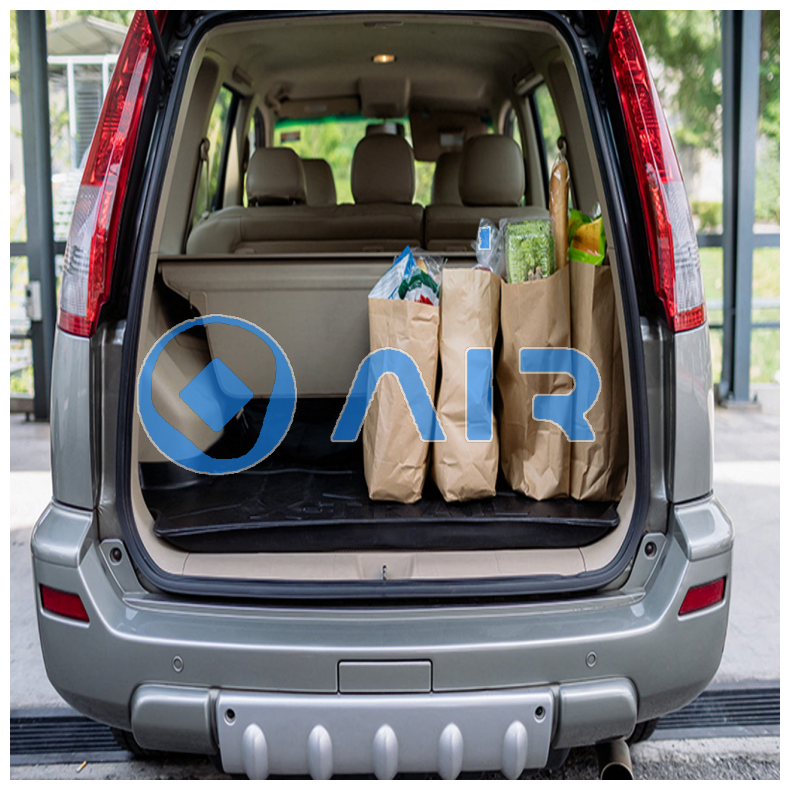

In [19]:
show_masks(adv_bedroom_image.permute(1, 2, 0).detach().cpu().numpy(), masks_new.detach().cpu().numpy() > 0, scores_new)

In [29]:
adv_bedroom_image_saved, delta, epsilon = train_init('../videos/adv_bedroom/00000.png')
adv_bedroom_image_saved = adv_bedroom_image_saved.cpu()
input_point = np.array([[224.0000, 663.7037]])
input_label = np.array([1])

In [30]:
masks_new, scores_new, logits = get_image_predict(predictor, adv_bedroom_image_saved, input_point)

In [45]:
# initial_image, delta, epsilon = train_init('../videos/adv_bedroom/00000.jpg')

initial_image = Image.open('../videos/adv_bedroom/00000.jpg')
# image = np.array(image.convert("RGB"))

tensor_initial_image = ToTensor()(initial_image)
tensor_initial_image = tensor_initial_image.to(device=device)

In [67]:
masks_new, scores_new, logits = get_image_predict(predictor, tensor_initial_image, np.array([[210, 350]], dtype=np.float32))

# Video

In [39]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "../../checkpoints/sam2_hiera_tiny.pt"
model_cfg = "sam2_hiera_t.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [40]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

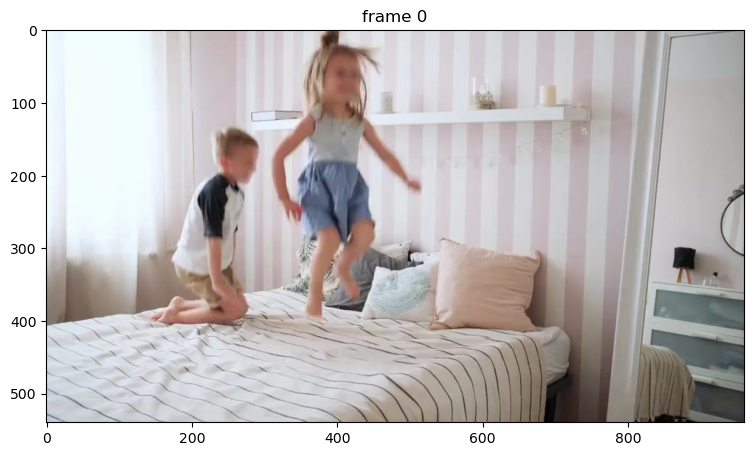

In [41]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "../videos/bedroom"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG", '.png']
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

In [56]:
inference_state = predictor.init_state(video_path=video_dir)

frame loading (JPEG): 100%|██████████| 200/200 [00:06<00:00, 32.51it/s]


/home/user20/segment-anything-2/sam2/sam2_video_predictor.py:867: UserWarning: cannot import name '_C' from 'sam2' (/home/user20/segment-anything-2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/segment-anything-2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(


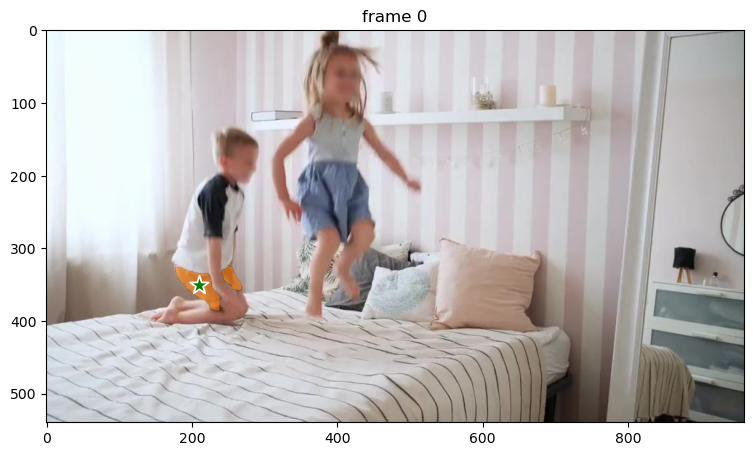

In [57]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's add a positive click at (x, y) = (210, 350) to get started
points = np.array([[210, 350]], dtype=np.float32)
# points = unnorm_coords
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

In [44]:
# # run propagation throughout the video and collect the results in a dict
# video_segments = {}  # video_segments contains the per-frame segmentation results
# with torch.no_grad():
#     for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
#         video_segments[out_frame_idx] = {
#             out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
#             for i, out_obj_id in enumerate(out_obj_ids)
#         }

propagate in video: 100%|██████████| 200/200 [00:20<00:00,  9.76it/s]


In [64]:
adv_mask = get_mask_logo(resize_to_shape=(540, 960))
_, delta, epsilon = train_init('../videos/bedroom/00000.jpg')
opt = optim.Adam([delta], lr=0.001)

dice_loss = DiceLoss('binary', from_logits=True)
losses = []
input_label = np.array([1])
input_point = np.array([[210, 350]], dtype=np.float32)

In [51]:
img_mean=np.array([0.485, 0.456, 0.406])
img_std=np.array([0.229, 0.224, 0.225])

In [78]:
i = 0
video_dir_initial = '../videos/bedroom'

for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    mask = (out_mask_logits[0])
    image = (np.array(Image.open(os.path.join(video_dir, frame_names[out_frame_idx]))) / 255.).transpose(2, 0, 1)

    opt.zero_grad()
    print(type(mask))
    print(mask.shape)
    print(mask)
    print(adv_mask.shape)
    loss = dice_loss(mask, adv_mask)
    losses.append(loss.item())
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)
    image[0] = image[0] * img_std[0] + img_mean[0]
    image[1] = image[1] * img_std[1] + img_mean[1]
    image[2] = image[2] * img_std[2] + img_mean[2]


    adv_image = ((image + delta.detach().cpu().numpy()).clip(0, 1).transpose(1, 2, 0) * 255.).astype(np.uint8)
    Image.fromarray(adv_image).save(f"{video_dir_initial}_{i}/{out_frame_idx}.png")

propagate in video:   0%|          | 0/200 [00:00<?, ?it/s]

<class 'torch.Tensor'>
torch.Size([1, 540, 960])
tensor([[[-16.1683, -16.1683, -17.0742,  ..., -18.3580, -19.0859, -19.0859],
         [-17.5391, -17.5391, -18.0396,  ..., -18.2578, -18.8083, -18.8083],
         [-20.6173, -20.6173, -20.2074,  ..., -18.0329, -18.1849, -18.1849],
         ...,
         [-17.2648, -17.2648, -17.4388,  ..., -17.5595, -17.7318, -17.7318],
         [-18.9862, -18.9862, -18.5475,  ..., -17.0525, -17.0946, -17.0946],
         [-19.7529, -19.7529, -19.0413,  ..., -16.8267, -16.8109, -16.8109]]],
       device='cuda:0')
torch.Size([1, 960, 540])


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [52]:
video_dir_initial = '../videos/bedroom'
for i in range(10):
    inference_state = predictor.init_state(video_path=f"{video_dir_initial}_{i}")
    with torch.no_grad():
        for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
            mask = (out_mask_logits[0] > 0.0).cpu().numpy()
            image = inference_state["images"][out_frame_idx]

            opt.zero_grad()
            loss = dice_loss(mask, adv_mask)
            losses.append(loss.item())
            loss.backward()
            opt.step()
            delta.data.clamp_(-epsilon, epsilon)

            adv_image = (image.detach().cpu().numpy() * img_std + img_mean + delta.detach().cpu().numpy()).clip(0, 1).transpose(1, 2, 0)
            Image.fromarray(adv_image * 255.).save(f"{video_dir_initial}_{i}/{out_frame_idx}.png")

            

RuntimeError: no images found in ../videos/bedroom_0